In [12]:
!pip install scikit-learn
!pip install pyspark
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install data-science-utils

In [13]:
# Importing libraries

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from ds_utils.unsupervised import plot_cluster_cardinality, plot_cluster_magnitude, plot_magnitude_vs_cardinality
from scipy.spatial.distance import euclidean

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [81]:
# Get preprocessed data

spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()
df = spark.read.option("inferSchema", "true").csv("../Preprocessing/NYC Taxi Duration Preprocessed/*.csv", header=True)
df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: integer (nullable = true)
 |-- trip_duration: integer (nullable = true)
 |-- distance: double (nullable = true)
 |-- week_day: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- quarter_of_year: integer (nullable = true)
 |-- hour: integer (nullable = true)



In [82]:
df.show()

+---------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+---------+--------+----+-----+---------------+----+
|vendor_id|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration| distance|week_day|year|month|quarter_of_year|hour|
+---------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+---------+--------+----+-----+---------------+----+
|        2|              1|      -73.982155|      40.767937|        -73.96463|       40.765602|                 0|          455|2.4444735|     Mon|2016|    3|              1|  17|
|        1|              1|      -73.980415|      40.738564|        -73.99948|        40.73115|                 0|          663|2.6599078|     Sun|2016|    6|              2|   0|
|        2|              1|       -73.97903|       40.76394|        -74.00533|       40.710087|     

# Clustering using sklearn

In [83]:
# Convert a week_day string column to an index.
df = df.drop(df["store_and_fwd_flag"])
week_day_col = StringIndexer(inputCol = 'week_day', outputCol = 'week_day_index')
df = week_day_col.fit(df).transform(df)
df.show(5)

+---------+---------------+----------------+---------------+-----------------+----------------+-------------+---------+--------+----+-----+---------------+----+--------------+
|vendor_id|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|trip_duration| distance|week_day|year|month|quarter_of_year|hour|week_day_index|
+---------+---------------+----------------+---------------+-----------------+----------------+-------------+---------+--------+----+-----+---------------+----+--------------+
|        2|              1|      -73.982155|      40.767937|        -73.96463|       40.765602|          455|2.4444735|     Mon|2016|    3|              1|  17|           6.0|
|        1|              1|      -73.980415|      40.738564|        -73.99948|        40.73115|          663|2.6599078|     Sun|2016|    6|              2|   0|           4.0|
|        2|              1|       -73.97903|       40.76394|        -74.00533|       40.710087|         2124| 3.669969| 

In [84]:
# creating a pandas and pyspark dataframe with all input columns.
input_col = df.drop(df["trip_duration"])
input_col = input_col.drop(df["week_day"])
input_col_pandas_df_without_cluster = input_col.toPandas()
input_col_pandas_df = input_col.toPandas()

## Elbow Method

In [85]:
# Calculating wcss for 10 clusters.
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0, n_init=10)
    kmeans.fit(input_col_pandas_df)
    wcss.append(kmeans.inertia_)
    
    print("k: ", str(i), ' & WCSS: ', kmeans.inertia_)

k:  1  & WCSS:  35823446.0077679
k:  2  & WCSS:  23456033.990897164
k:  3  & WCSS:  12488353.063743751
k:  4  & WCSS:  10051217.83052335
k:  5  & WCSS:  8670906.588276137
k:  6  & WCSS:  7718426.417964043
k:  7  & WCSS:  6983184.461529455
k:  8  & WCSS:  6554075.1456356095
k:  9  & WCSS:  6140605.750927838
k:  10  & WCSS:  5861702.296269095


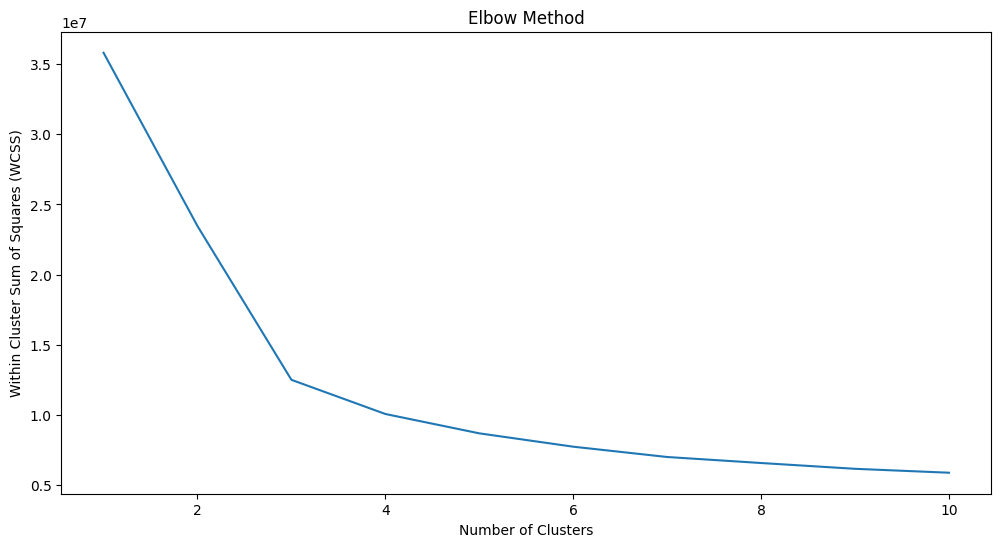

In [86]:
# Plotting WCSS graph.
plt.figure(figsize=(12, 6), dpi=100)

plt.plot(range(1, 11), wcss)

plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')

plt.show()

In [87]:
#Using StandardScaler to set all the columns in the dataframe to the same scale.
std_scaler = StandardScaler()
X = std_scaler.fit_transform(input_col_pandas_df)

X = pd.DataFrame(X, columns = input_col_pandas_df.columns)
X

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,year,month,quarter_of_year,hour,week_day_index
0,0.932331,-0.508690,-0.295293,0.608563,0.085584,0.394951,-0.482016,0.0,-0.315667,-1.013856,0.527376,1.562618
1,-1.072580,-0.508690,-0.257719,-0.345022,-0.723479,-0.542761,-0.447158,0.0,1.469916,0.986333,-2.057367,0.557727
2,0.932331,-0.508690,-0.227810,0.478802,-0.859290,-1.116052,-0.283727,0.0,-1.506056,-1.013856,-0.384886,1.060173
3,-1.072580,1.778467,-0.011651,0.280767,0.253316,0.402953,-0.615457,0.0,1.469916,0.986333,1.287595,-1.452054
4,0.932331,-0.508690,-0.017265,1.577407,1.064351,0.257718,0.178782,0.0,0.874721,0.986333,-0.993061,-0.949608
...,...,...,...,...,...,...,...,...,...,...,...,...
395992,0.932331,-0.508690,0.177948,2.080934,-0.190217,0.682862,-0.510484,0.0,-0.910862,-1.013856,-0.688974,0.055282
395993,0.932331,1.016081,0.121587,0.749557,-0.387549,-0.602640,-0.377452,0.0,-0.315667,-1.013856,-0.232843,0.055282
395994,0.932331,0.253695,0.296285,0.972914,1.224075,1.471365,0.006367,0.0,-0.315667,-1.013856,-1.905324,0.557727
395995,-1.072580,-0.508690,0.568591,2.993646,0.283961,0.836235,-0.563023,0.0,1.469916,0.986333,0.375332,-0.447163


In [88]:
# We can see that the graph above levels off at around k=4. So we will use that as our number of clusters.
# Now we will create a k-means clustering model that uses 4 clusters (k=4)

kmeans_cluster = KMeans(n_clusters = 4, init = 'k-means++', random_state = 0)
clusters_prediction = kmeans_cluster.fit_predict(X)

kmeans_fit = kmeans_cluster.fit(X)

/Users/adarshdudhat/Desktop/University Of Calgary/Classes/FALL - 2022/SENG - 550/Project/seng550final/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/adarshdudhat/Desktop/University Of Calgary/Classes/FALL - 2022/SENG - 550/Project/seng550final/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


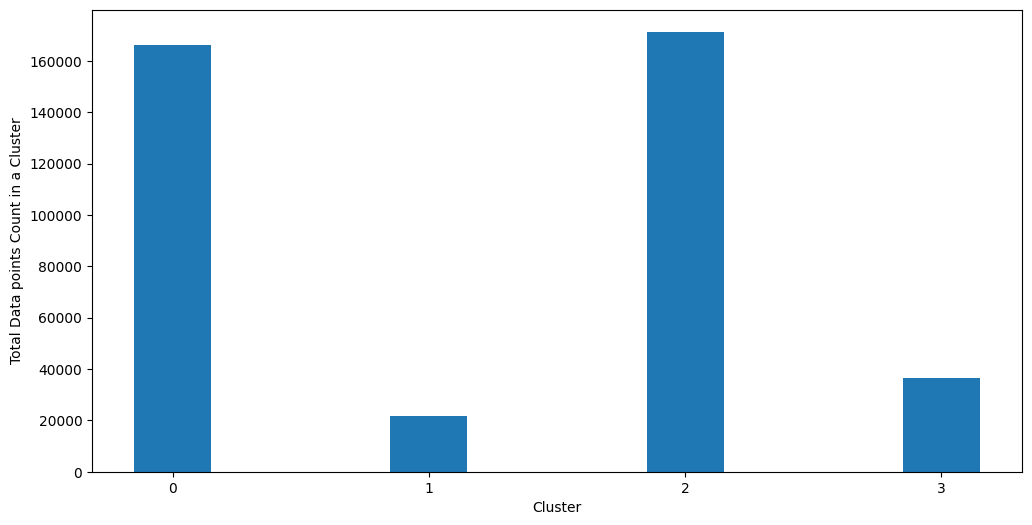

In [89]:
# Graph out the size of each cluster.
input_col_pandas_df['cluster'] = clusters_prediction
cluster_counts = input_col_pandas_df.groupby(['cluster'])['cluster'].count()

plt.figure(figsize=(12, 6), dpi=100)

plt.bar(['0', '1', '2', '3'], cluster_counts.values, width = 0.3)

plt.xlabel('Cluster')
plt.ylabel('Total Data points Count in a Cluster')

plt.show()

In [90]:
# Print total data points in each 4 clusters.
for i in range(len(cluster_counts.values)):
    print("Cluster: ", i, " Total Data Points: ", cluster_counts.values[i])

Cluster:  0  Total Data Points:  166291
Cluster:  1  Total Data Points:  21841
Cluster:  2  Total Data Points:  171308
Cluster:  3  Total Data Points:  36557


## Cluster diagnoses

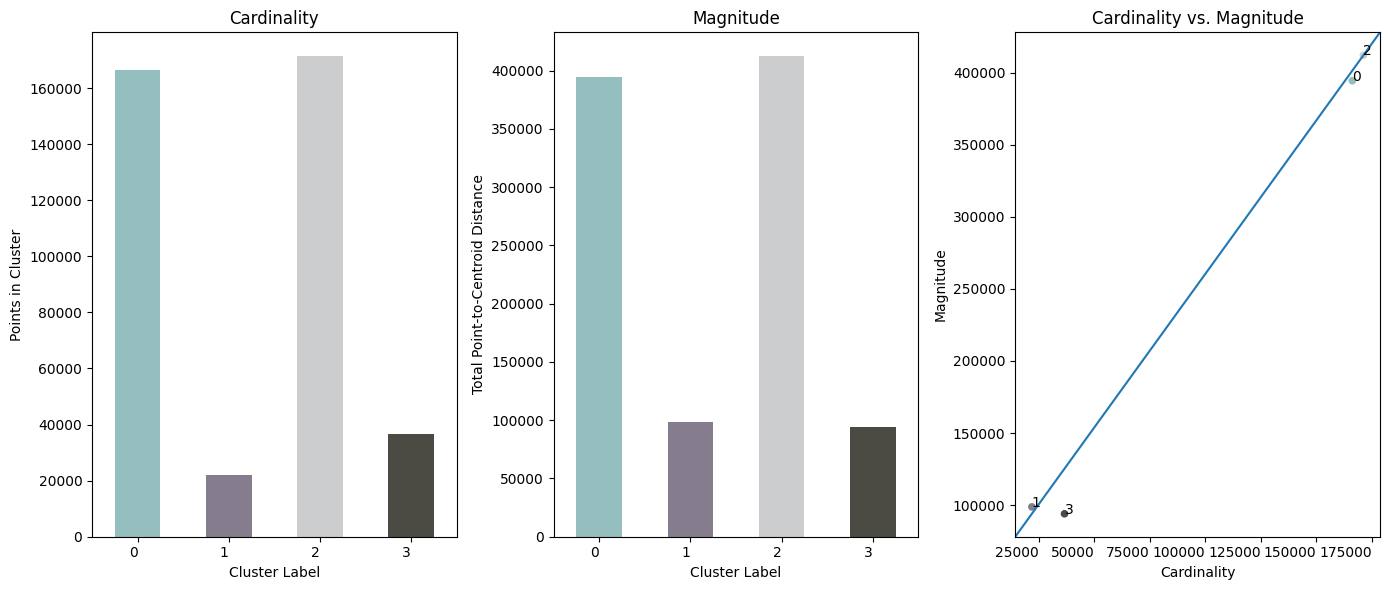

In [91]:
# Different cluster colors.
cluster_colors = ['#94BFBE', '#857C8D', '#CCCDCE', '#4B4B44', '#F1A340', '#5C0029']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))

# plot cardinality and magnitude of each cluster.
plot_cluster_cardinality(kmeans_fit.labels_, ax = ax1, title = "Cardinality", color = cluster_colors)
plot_cluster_magnitude(X, kmeans_fit.labels_, kmeans_fit.cluster_centers_, euclidean, ax = ax2, title="Magnitude", color = cluster_colors)
plot_magnitude_vs_cardinality(X, kmeans_fit.labels_, kmeans_fit.cluster_centers_, euclidean, color = cluster_colors[0 : kmeans_fit.n_clusters], ax = ax3, title = "Cardinality vs. Magnitude")

fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

## Feature diagnose per cluster

In [92]:
# Add a cluster column in dataframes.
input_col_pandas_df['cluster'] = kmeans_cluster.labels_
X['cluster'] = kmeans_cluster.labels_

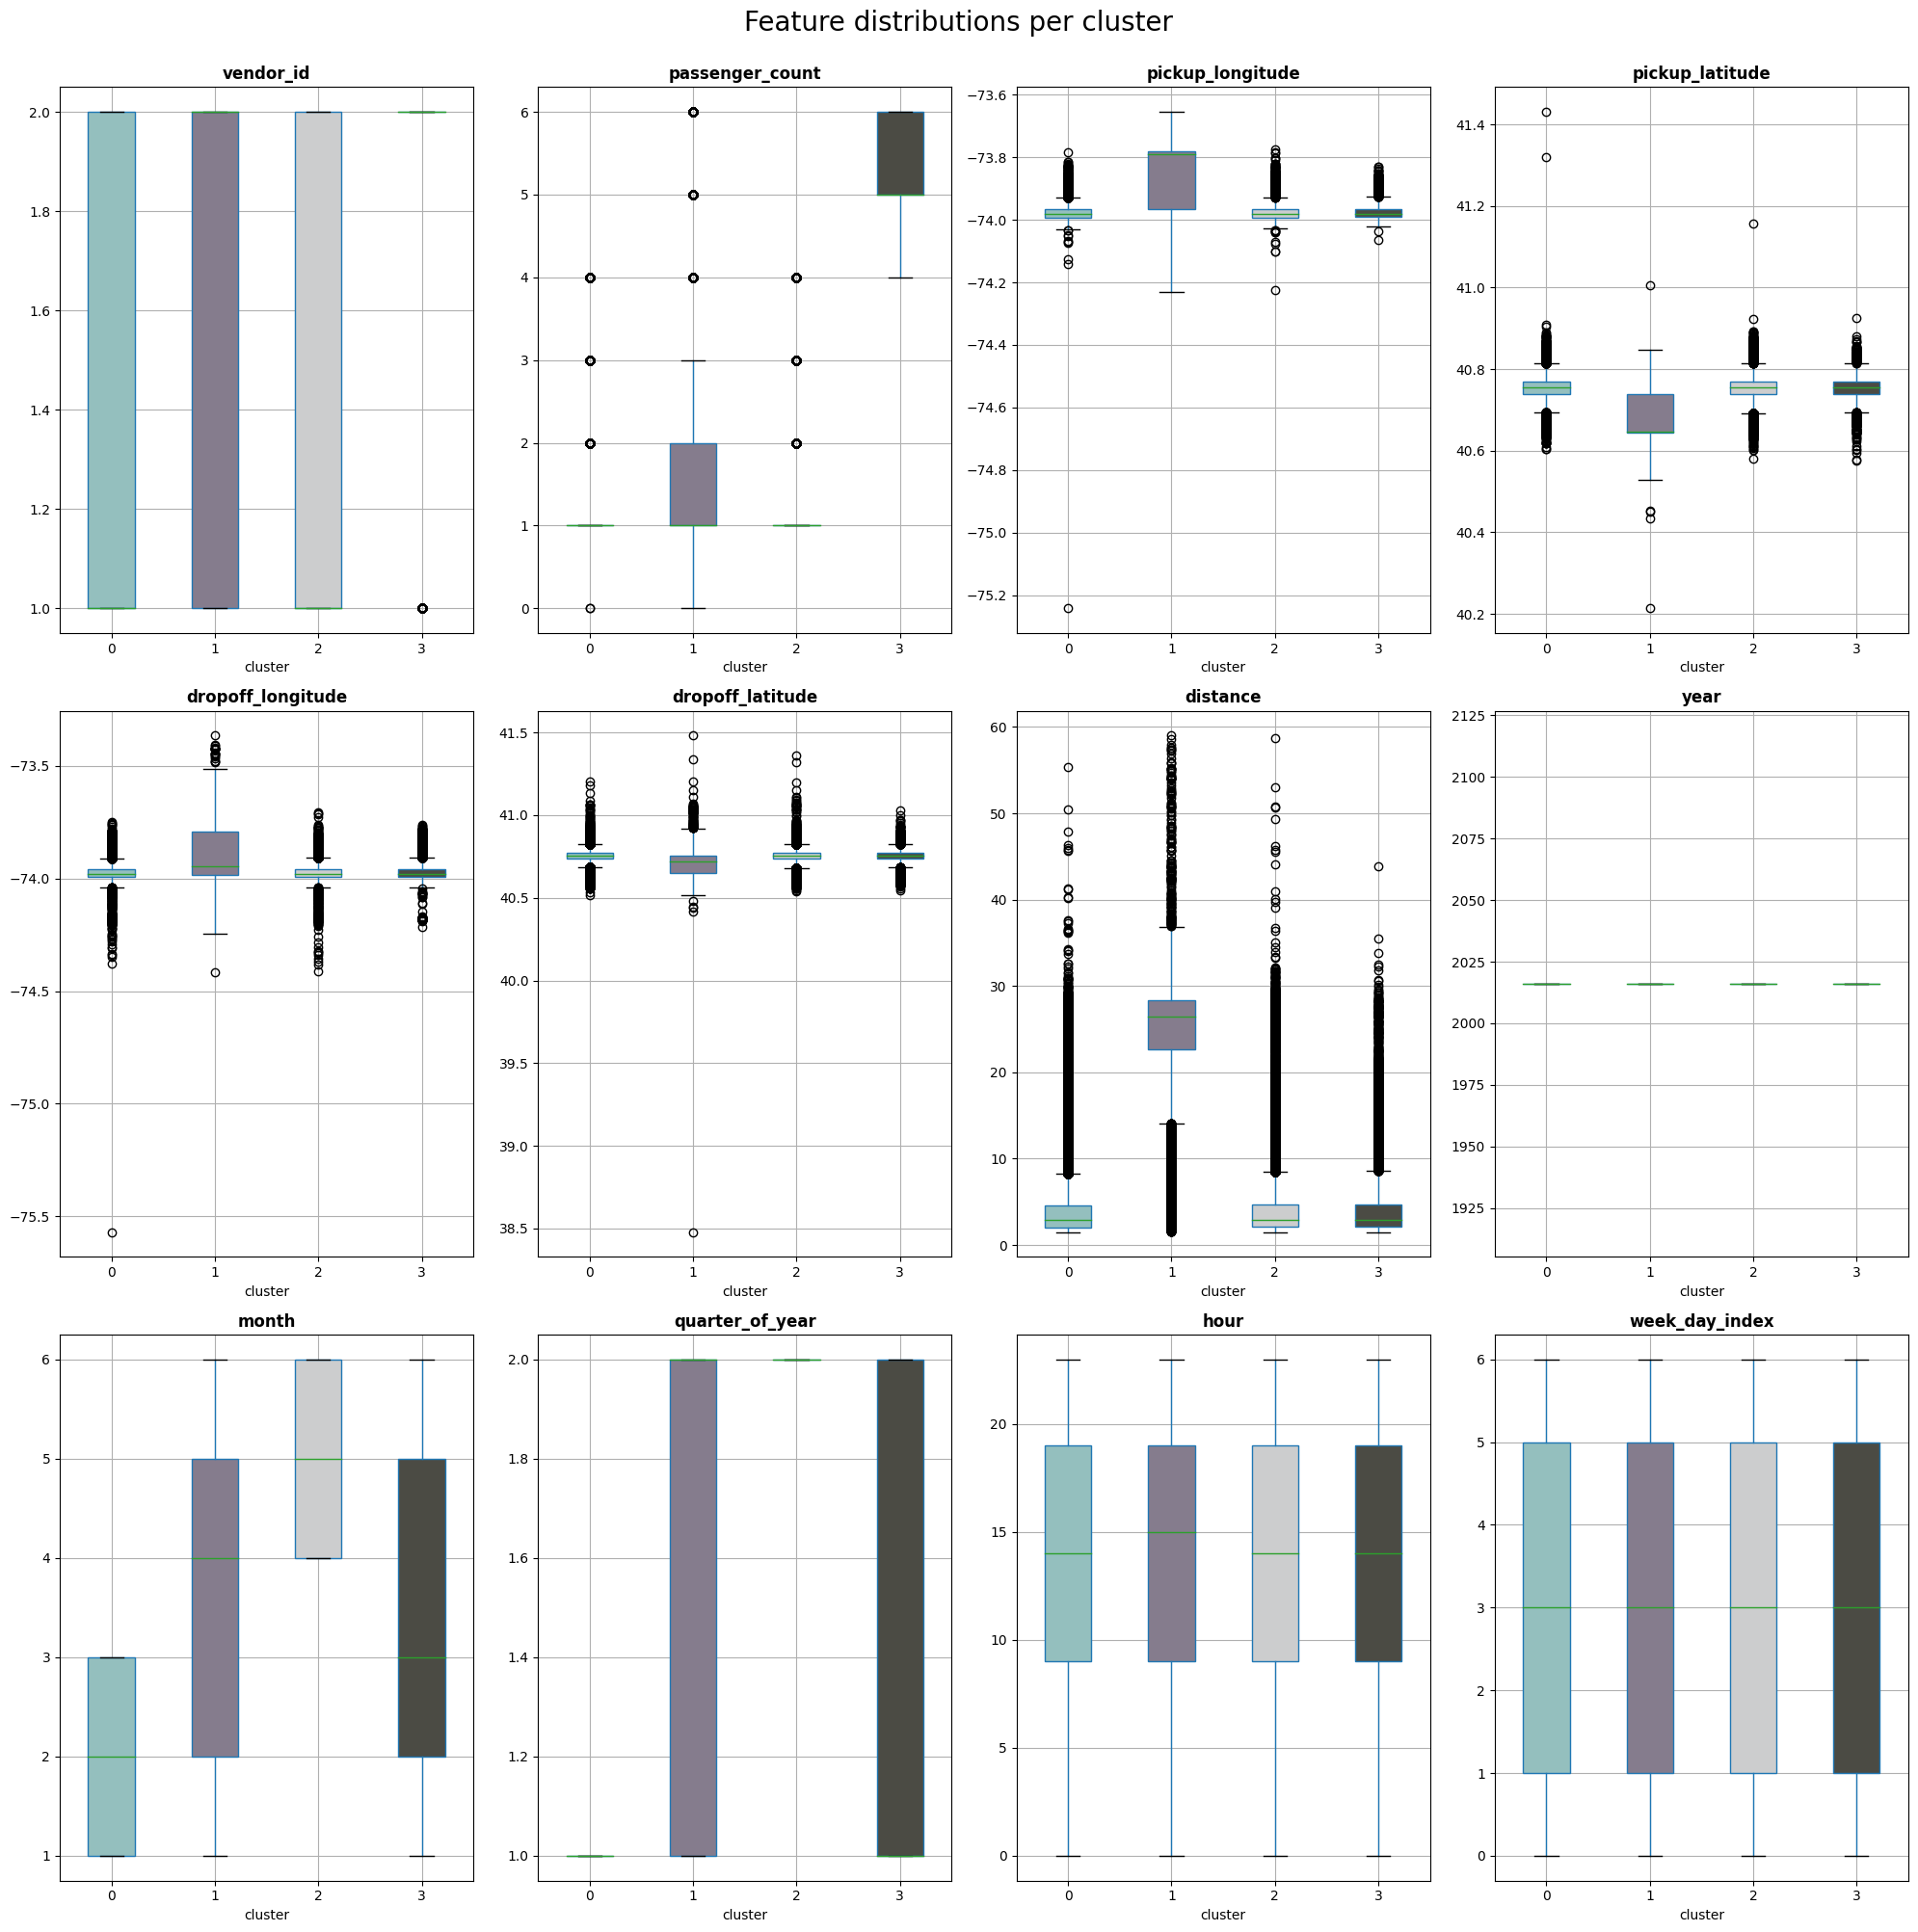

In [93]:
# Get features from kmeans model.
features = kmeans_cluster.feature_names_in_
n_cols = 4
n_rows = len(features) // n_cols + (len(features) % n_cols > 0)

fig = plt.figure(figsize = (20,20))

# Create a box for each feature in each cluster.
for n, feature in enumerate(features):
    ax = plt.subplot(n_rows, n_cols, n + 1)
    box = input_col_pandas_df[[feature, 'cluster']].boxplot(by = 'cluster', ax = ax, return_type = 'both', patch_artist = True)

    for row_key, (ax, row) in box.items():
        ax.set_xlabel('cluster')
        ax.set_title(feature, fontweight = "bold")
        for i, box in enumerate(row['boxes']):
            box.set_facecolor(cluster_colors[i])

fig.suptitle('Feature distributions per cluster', fontsize = 20, y = 1)   
plt.tight_layout()
plt.show()

## Data Preparation for Radar

In [94]:
# Calculate mean for each feature in each cluster.
X_mean = pd.concat([pd.DataFrame(X.mean().drop('cluster'), columns=['mean']), X.groupby('cluster').mean().T], axis = 1)
X_mean.drop(columns=['mean'], inplace=True)

X_mean

,0,1,2,3
vendor_id,-0.098066,0.055865,-0.109343,0.925092
passenger_count,-0.300208,0.025165,-0.290359,2.711194
pickup_longitude,-0.158642,2.642086,-0.154917,-0.130937
pickup_latitude,0.131116,-2.222794,0.127117,0.135909
dropoff_longitude,-0.101386,1.659185,-0.095520,-0.082480
dropoff_latitude,0.063276,-1.059515,0.060757,0.060466
distance,-0.187411,3.043984,-0.171285,-0.163478
year,0.000000,0.000000,0.000000,0.000000
month,-0.884719,0.023120,0.861630,-0.027033
quarter_of_year,-1.013856,0.021634,0.986333,-0.023090


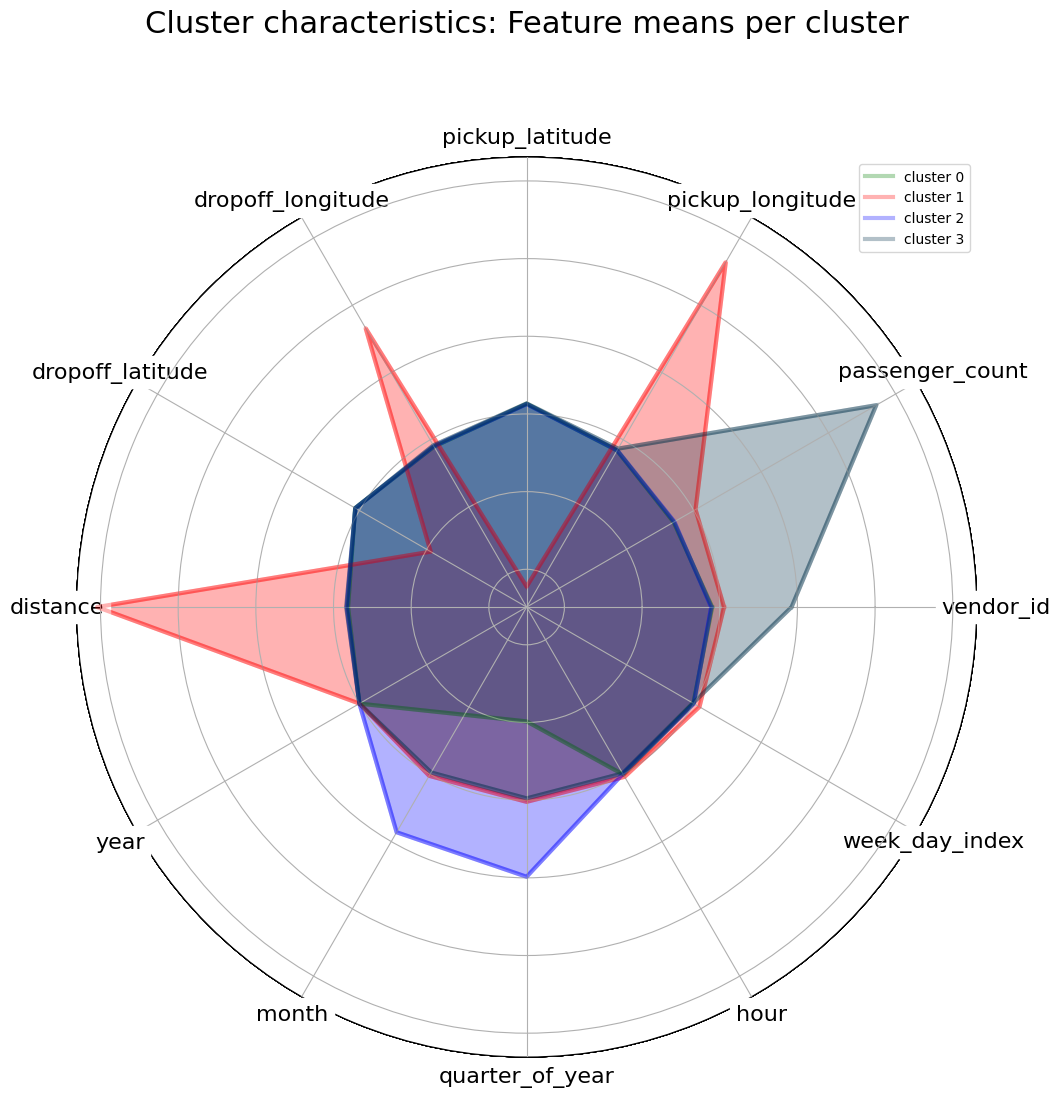

In [96]:
class Radar(object):
    def __init__(self, figure, title, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.9, 0.9]

        self.n = len(title)
        self.angles = np.arange(0, 360, 360.0/self.n)
        
        self.axes = [figure.add_axes(rect, projection = 'polar', label = 'axes%d' % i) for i in range(self.n)]
        self.ax = self.axes[0]
        
        # Feature names
        self.ax.set_thetagrids(self.angles, labels = title, fontsize = 16, backgroundcolor = "white",zorder = 999)
        self.ax.set_yticklabels([])
        
        for ax in self.axes[1:]:
            ax.xaxis.set_visible(False)
            ax.set_yticklabels([])
            ax.set_zorder(-99)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.spines['polar'].set_color('black')
            ax.spines['polar'].set_zorder(-99)

    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)
        kw['label'] = '_noLabel'
        self.ax.fill(angle, values,*args,**kw)

# Radar clusters.
radar_cluster_color = ["green", "red", "blue", "#003049"]
fig = plt.figure(figsize = (12, 10))
radar = Radar(fig, kmeans_cluster.feature_names_in_, np.unique(kmeans_cluster.labels_))

# Get data for each cluster and plot it in a radar.
for cluster in range(0, kmeans_cluster.n_clusters):
    cluster_data = X_mean[cluster].values.tolist()
    radar.plot(cluster_data,  '-', lw = 3, color = radar_cluster_color[cluster], alpha=0.3, label='cluster {}'.format(cluster))

radar.ax.legend()
radar.ax.set_title("Cluster characteristics: Feature means per cluster", size = 22, pad = 90)
plt.show()